In [45]:
import pandas as pd
import numpy as np
import urllib.request
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from transformers import AutoTokenizer, TFGPT2Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [2]:
total_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

In [3]:
total_dataset.head()

,text,category
0,이에 따른다면 초등학생들의 소비 문화는 디지털 강국의 ‘개국 공신’이 되려는 몸부림...,연예/문화
1,"""지난 14일 우리정부가 난민 신청을 한 예멘인들에 대해 인도적 체류를 허가했는데요...",연예/문화
2,인천시 서구와 계양구에서 경기도 부천을 거쳐 서울 홍대까지 지하철이 건설될 것으로 ...,생활
3,김성태 자유한국당 의원이 최근 황운하 울산경찰청장과 벌인 ‘미친개’ 공방을 언급하며...,정치
4,"""지난해 사상 최대 실적을 거뒀던 우리 수출이 새해에도 좋은 흐름을 이어갔습니다. ...",스포츠


In [4]:
len(total_dataset)

37648

In [5]:
len(test_dataset)

3103

In [6]:
total_dataset["text"].nunique()

35837

In [7]:
total_dataset.drop_duplicates(subset=['text'], inplace=True)

In [8]:
total_dataset.groupby('category').size().reset_index(name = 'count')

,category,count
0,경제,3659
1,사회,5471
2,생활,4956
3,스포츠,4347
4,연예/문화,10278
5,정치,7126


In [9]:
total_dataset.isnull().sum()

text        0
category    0
dtype: int64

In [10]:
train_data, test_data = train_test_split(total_dataset, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 26877
테스트용 리뷰의 개수 : 8960


In [11]:
train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")
test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")

C:\Users\JH\AppData\Local\Temp\ipykernel_17144\494860855.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['text'] = train_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")
C:\Users\JH\AppData\Local\Temp\ipykernel_17144\494860855.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['text'] = test_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힇 ]","")


In [12]:
labels = ['경제','사회','생활','스포츠','연예/문화','정치']
num = 0
for label in labels:
    train_data['category'].replace(label, num, inplace=True)
    test_data['category'].replace(label, num, inplace=True)
    num += 1

In [13]:
tokenizer = AutoTokenizer.from_pretrained('skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', pad_token='<pad>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
stopwords = pd.read_table("한국어불용어100.txt")
stopwords_ko = stopwords['이'].values
stopwords_ko = np.append(stopwords_ko, '이')

In [15]:
# '_' 가 붙은 토큰을 위해 추가적인 불용어 추가
for word in stopwords_ko:
    text = "_"+word
    stopwords_ko = np.append(stopwords_ko, text)

In [16]:
max_seq_len = 640

In [17]:
def Tokenizer(text, category, max_seq_len, tokenizer):

    input_ids, data_labels = [], []
    
    for example, label in tqdm(zip(text, category), total=len(text)):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        stopwords_removed_sentence = [word for word in tokens if not word in stopwords_ko]
        input_id = tokenizer.convert_tokens_to_ids(stopwords_removed_sentence)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return input_ids, data_labels

In [18]:
train_X, train_y = Tokenizer(train_data['text'], train_data['category'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|███████████████████████████████████████████████████████████████████████████| 26877/26877 [01:21<00:00, 328.79it/s]


In [19]:
test_X, test_y = Tokenizer(test_data['text'], test_data['category'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████| 8960/8960 [00:26<00:00, 333.03it/s]


In [22]:
def Tokenizer_testdata(text, max_seq_len, tokenizer):

    input_ids = []
    
    for example in tqdm(text):

        bos_token = [tokenizer.bos_token]
        eos_token = [tokenizer.eos_token]
        tokens = bos_token + tokenizer.tokenize(example) + eos_token
        stopwords_removed_sentence = [word for word in tokens if not word in stopwords_ko]
        input_id = tokenizer.convert_tokens_to_ids(stopwords_removed_sentence)
        input_id = pad_sequences([input_id], maxlen=max_seq_len, value=tokenizer.pad_token_id, padding='post')[0]

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        input_ids.append(input_id)
        

    input_ids = np.array(input_ids, dtype=int)

    return input_ids

In [23]:
X_test = Tokenizer_testdata(test_dataset['text'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|█████████████████████████████████████████████████████████████████████████████| 3103/3103 [00:09<00:00, 315.89it/s]


In [24]:
from sklearn import preprocessing

In [26]:
#GPT 모델 불러오기
model = TFGPT2Model.from_pretrained('skt/kogpt2-base-v2', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.7.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [27]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
outputs = model([input_ids_layer])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
class TFGPT2ForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name, num_labels):
        super(TFGPT2ForSequenceClassification, self).__init__()
        self.gpt = TFGPT2Model.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(num_labels,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='softmax',
                                                name='classifier')

    def call(self, inputs):
        outputs = self.gpt(input_ids=inputs)
        cls_token = outputs[0][:, -1]
        prediction = self.classifier(cls_token)

        return prediction

In [29]:
model = TFGPT2ForSequenceClassification("skt/kogpt2-base-v2", num_labels=6)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2Model: ['transformer.h.7.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'lm_head.weight', 'transformer.h.1.attn.masked_bias', 'transformer.h.9.attn.masked_bias']
- This IS expected if you are initializing TFGPT2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All t

In [30]:
import tensorflow_addons

In [43]:
es = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001,
    
    patience=2)

mc = ModelCheckpoint('best_model3.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(
    train_X, train_y, epochs=1, batch_size=2, validation_data=(test_X, test_y),
    callbacks=[es, mc]
)

13439/13439 [==============================] - 3947s 294ms/step - loss: 0.6247 - accuracy: 0.7903 - val_loss: 0.4986 - val_accuracy: 0.8358


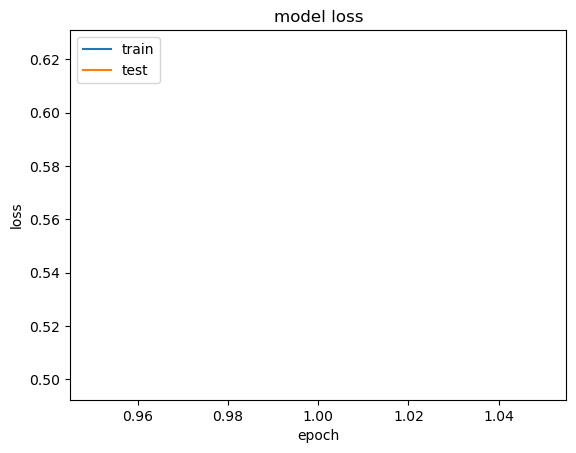

In [46]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
predict = history.model.predict(X_test)

97/97 [==============================] - 94s 962ms/step


In [49]:
y_predicted = np.argmax(predict, axis=-1)

In [52]:
test = test_dataset

In [53]:
test["category"] = y_predicted

labels = ['경제','사회','생활','스포츠','연예/문화','정치']
num = 0
for label in labels:
    test['category'].replace(num, label, inplace=True)
    num += 1
test.groupby('category').size().reset_index(name = 'count')

submission = pd.DataFrame({
    'ID' : test['ID'],
    'text' : test['text'],
    'category' : test['category']
})

submission.to_csv('submission3.csv', index=False)